Test Row Features: [  0.    118.     84.     47.    230.     45.8     0.551  31.   ]
True Outcome: 0
Predicted Probability (p): 0.3303
Final Prediction (0 or 1): 0
--------------------
Test Row Features: [  8.    183.     64.      0.      0.     23.3     0.672  32.   ]
True Outcome: 1
Predicted Probability (p): 0.5337
Final Prediction (0 or 1): 1
--------------------


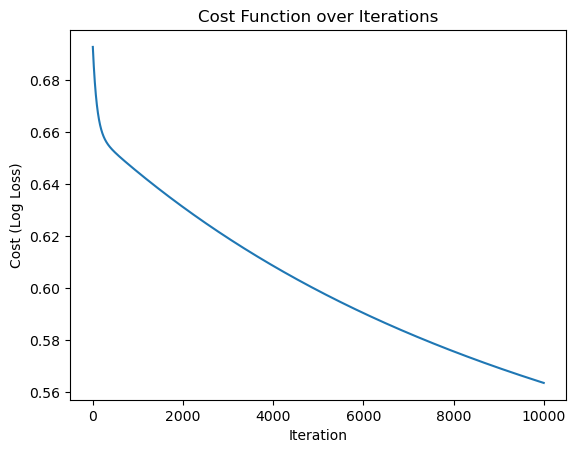

Final Accuracy: 72.01%
Coefficients (w): [ 1.0156558   1.69317884 -0.64122625  0.08556709  0.41518047  0.51621138
  0.54064212  0.42820312]
Bias (b): -2.0620862552903616
Learning rate (alpha): 0.01
Lowest cost: 0.5635698883307533


In [1]:
import matplotlib.pyplot as plt
import numpy as np


class LogisticRegression:
    def __init__(self, csv_path, y_column_name):
        self.fields = np.loadtxt(csv_path, delimiter=',', max_rows=1, dtype=str)
        self.np_data_arr = np.loadtxt(csv_path, delimiter=',', skiprows=1,dtype=float)
        self.Y_train = self.np_data_arr[:, np.where(self.fields == y_column_name)[0]].flatten()
        self.X_train = np.delete(self.np_data_arr, np.where(self.fields == y_column_name)[0], 1)
        self.alpha = .001
        self.colCount = self.X_train.shape[1]
        self.w_list = np.zeros(self.colCount)
        self.b = 0.0
        self.costs = []
        self.max = [self.X_train[:,i].max() for i in range(self.colCount)]
        for i in range(self.colCount):
            # Avoid division by zero if a column is all zeros
            if self.max[i] != 0:
                self.X_train[:,i] /= self.max[i]

    def __str__(self):
        # Plotting the cost
        plt.plot(self.costs)
        plt.title("Cost Function over Iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Cost (Log Loss)")
        plt.show()

        # Calculate and display accuracy
        accuracy = self.accuracy(self.X_train, self.Y_train, scaled=True)

        return (f'Final Accuracy: {accuracy:.2%}\n'
                f'Coefficients (w): {self.w_list}\n'
                f'Bias (b): {self.b}\n'
                f'Learning rate (alpha): {self.alpha}\n'
                f'Lowest cost: {self.costs[-1]}')

    def set_alpha(self, alpha):
        self.alpha = alpha

    def sigmoid(self,z):
        return 1/(1 + np.exp(-z))

    def predict_proba(self, x, scaled=True): # Renamed to be clearer
        if not scaled:
            # Important: Use a copy to not modify the original input array
            x_scaled = x.copy()
            for i in range(x_scaled.shape[1]):
                if self.max[i] != 0:
                    x_scaled[:,i] /= self.max[i]
            x = x_scaled
        return self.sigmoid(np.matmul(x, self.w_list) + self.b)

    def predict(self, x, scaled=True): # New function for predicting 0 or 1
        probabilities = self.predict_proba(x, scaled)
        return (probabilities >= 0.5).astype(int)

    def cost(self, g):
        m = self.X_train.shape[0]
        # **FIX 1: ADDED EPSILON FOR NUMERICAL STABILITY**
        # This prevents log(0) which results in NaN or inf.
        epsilon = 1e-15
        g = np.clip(g, epsilon, 1 - epsilon)

        # The formula itself was correct, but this makes it robust.
        return -(np.sum(self.Y_train * np.log(g) + (1 - self.Y_train) * np.log(1-g)))/m

    def _update(self):
        m = self.X_train.shape[0]
        # Use the clearer function name
        g = self.predict_proba(self.X_train, scaled=True)

        # The error term and gradients are correct.
        err = g - self.Y_train
        dj_dw = (self.X_train.T @ err) / m
        dj_db = np.sum(err) / m

        self.w_list = self.w_list - (self.alpha * dj_dw)
        self.b = self.b - (self.alpha * dj_db)

        # We calculate the cost using the predictions from the *current* parameters
        current_g = self.predict_proba(self.X_train, scaled=True)
        self.costs.append(self.cost(current_g))

        # No need to return self.w_list, self.b as they are instance attributes

    # **FIX 2: ADDED AN ACCURACY FUNCTION FOR PROPER EVALUATION**
    def accuracy(self, x, y_true, scaled=True):
        y_pred = self.predict(x, scaled)
        # Accuracy is the mean of cases where the prediction was correct
        return np.mean(y_pred == y_true)

    def train(self, iterations):
        # Clear previous training history
        self.costs = []
        for i in range(iterations):
            self._update()
        return True

if __name__ == '__main__':
    l = LogisticRegression(csv_path='data/diabetes.csv', y_column_name='Outcome')
    l.set_alpha(0.01)
    l.train(10000)

    # Let's test the same row as before
    test_row = np.array([[0,118,84,47,230,45.8,0.551,31]])

    # The true outcome for this row in the dataset is 0
    print(f"Test Row Features: {test_row.flatten()}")
    print(f"True Outcome: 0")
    print(f"Predicted Probability (p): {l.predict_proba(test_row, scaled=False)[0]:.4f}")
    print(f"Final Prediction (0 or 1): {l.predict(test_row, scaled=False)[0]}")
    print("-" * 20)

    # Let's test another row with outcome 1 (row 3 of the dataset)
    test_row_2 = np.array([[8,183,64,0,0,23.3,0.672,32]])
    print(f"Test Row Features: {test_row_2.flatten()}")
    print(f"True Outcome: 1")
    print(f"Predicted Probability (p): {l.predict_proba(test_row_2, scaled=False)[0]:.4f}")
    print(f"Final Prediction (0 or 1): {l.predict(test_row_2, scaled=False)[0]}")
    print("-" * 20)

    # Print the full summary, which now includes accuracy
    print(l)